# Rectmagnet Class 
---

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys, os
root = os.path.join(os.getcwd(), '../')
sys.path.append(root)

import math

import numpy as np

from pmd_beamphysics import single_particle

from scipy.constants import physical_constants

from gpt import GPT

MC2 = physical_constants['electron mass energy equivalent in MeV'][0]*1e6
c = physical_constants['speed of light in vacuum'][0]

## Basic Usage

In [2]:
from gpt.bstatic import Rectmagnet

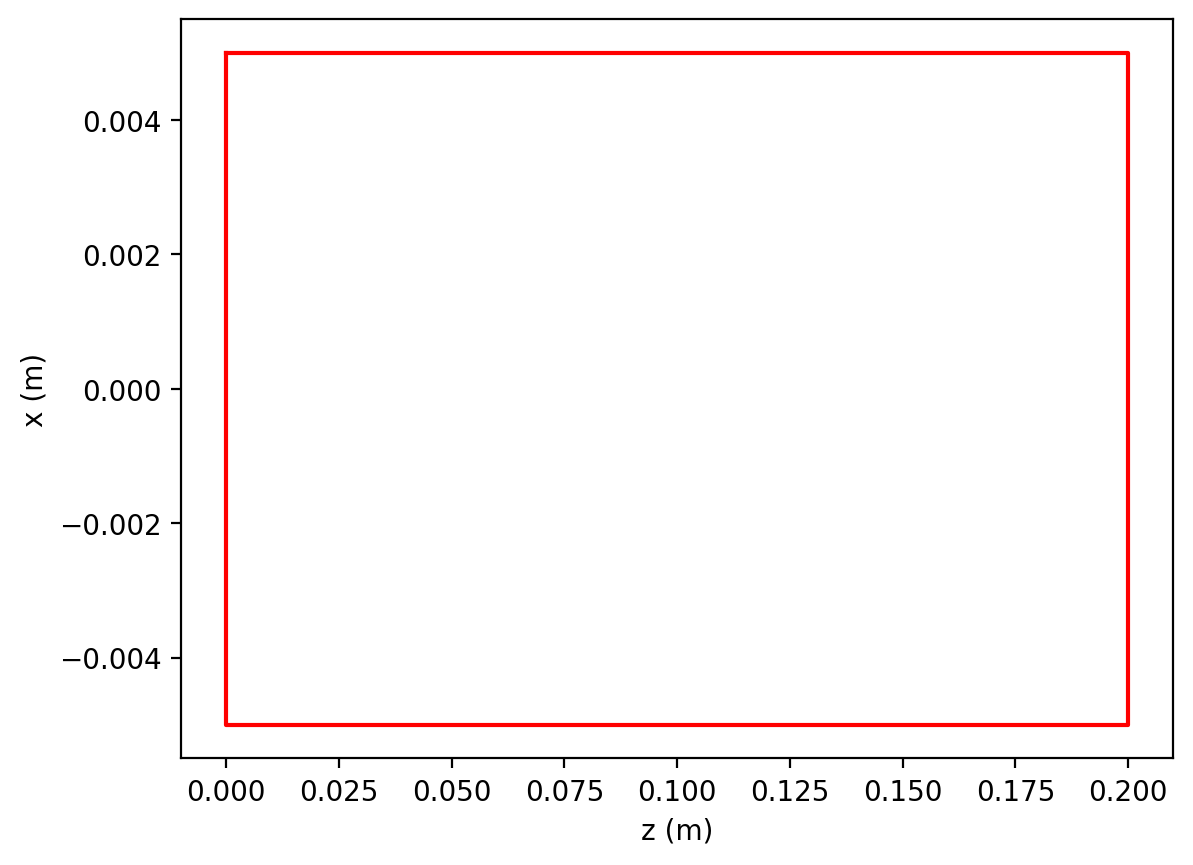

In [3]:
RM = Rectmagnet('kicker', 0.01, 0.2, 0.001)
RM.place()
RM.plot_floor()

In [4]:
RM.gpt_lines()

['\n#***********************************************',
 '#             Rectmagnet: kicker           ',
 '#***********************************************',
 'kicker_x = 0;',
 'kicker_y = 0;',
 'kicker_z = 0.1;\nkicker_yaw = 0;',
 'kicker_pitch = 0;',
 'kicker_roll = 0;\n',
 'kicker_a = 0.01;',
 'kicker_b = 0.2;',
 'kicker_Bfield = 0.001;',
 'kicker_fringe_dl = 0;',
 'kicker_fringe_b1 = 0;',
 'kicker_fringe_b2 = 0;',
 '\nrectmagnet("wcs", "GxyzXYZ", kicker_x, kicker_y, kicker_z, kicker_yaw, kicker_pitch, kicker_roll, kicker_a, kicker_b, kicker_Bfield,kicker_fringe_dl, kicker_fringe_b1, kicker_fringe_b2);']

## With Lattice Generation

In [5]:
from gpt.lattice import Lattice

In [6]:
lat = Lattice('werd')

b = 0.2

kick = 1e-3
E = 1e6
p = np.sqrt(E**2 - MC2**2)

Bfield = p * kick / b / c

gap = 0.01

ds = 0.4

lat.add(Rectmagnet('kicker', 0.05, b, Bfield, gap=gap), ds = ds, element_origin='beg')

$\Delta\theta_x  = \frac{eB\cdot L}{p} $, $B = \frac{p\Delta\theta_x }{e L}$

<Axes: xlabel='z (m)', ylabel='x (m)'>

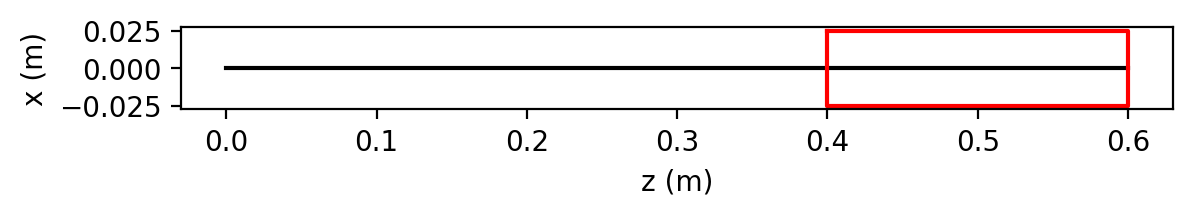

In [7]:
lat.plot_floor()

In [8]:
lat.write_gpt_lines(output_file='gpt.temp.in');

In [9]:
G = GPT('gpt.temp.in', initial_particles=single_particle(pz=p), load_fields=True)
G.set_variable('Ntout', 500)
G.run()

In [10]:
#G.lattice.plot_floor()

In [11]:
#print(G)

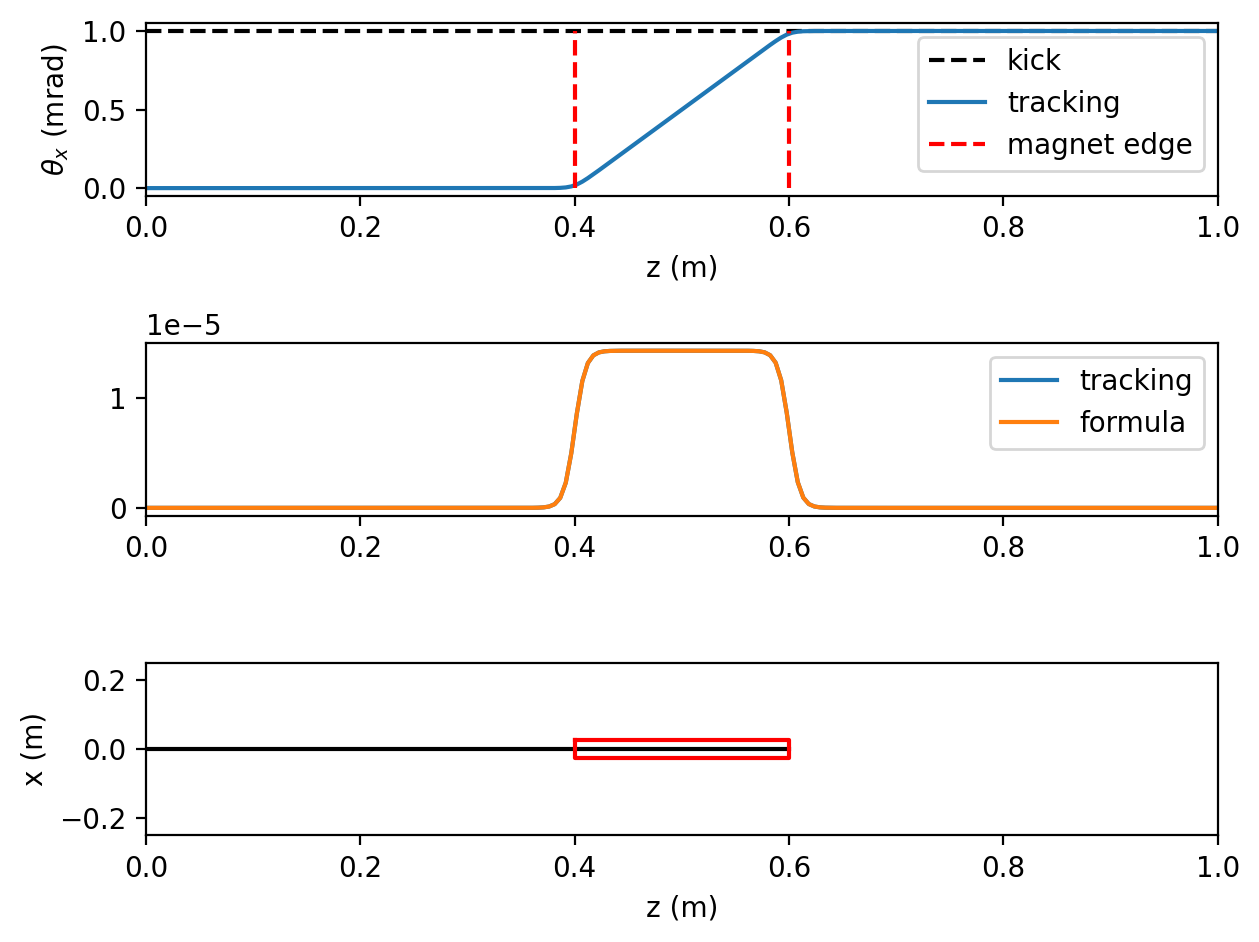

In [12]:
fig, axs = plt.subplots(3, 1)

axs[0].plot([0, 1], [1, 1], '--k')
axs[0].plot(G.tout_stat('mean_z'), G.tout_stat('mean_xp')*1e3);
axs[0].set_xlabel('z (m)')
axs[0].set_ylabel(r'$\theta_x$ (mrad)')
axs[0].set_xlim([0, 1])

axs[0].plot(ds + np.array([0, 0]), [0, 1], '--r')
axs[0].plot(ds + np.array([b, b]), [0, 1], '--r')

axs[0].legend(['kick', 'tracking', 'magnet edge'])

axs[1].plot(G.tout_stat('mean_z'), G.tout_stat('mean_fBy'))
axs[1].plot(G.tout_stat('mean_z'), lat['kicker'].b_field(G.tout_stat('mean_z')))
axs[1].legend(['tracking', 'formula'])
axs[1].set_xlim([0, 1])

lat.plot_floor(ax=axs[2],axis=None)
axs[2].set_xlim([0, 1])
axs[2].set_ylim([-0.25, +0.25])

plt.tight_layout()

In [13]:
G2 = GPT('gpt.temp.in', initial_particles=single_particle(pz=p), load_all_gdf_data=True)
G2.set_variable('Ntout', 500)
G2.run()

In [14]:
#print(G2.lattice)

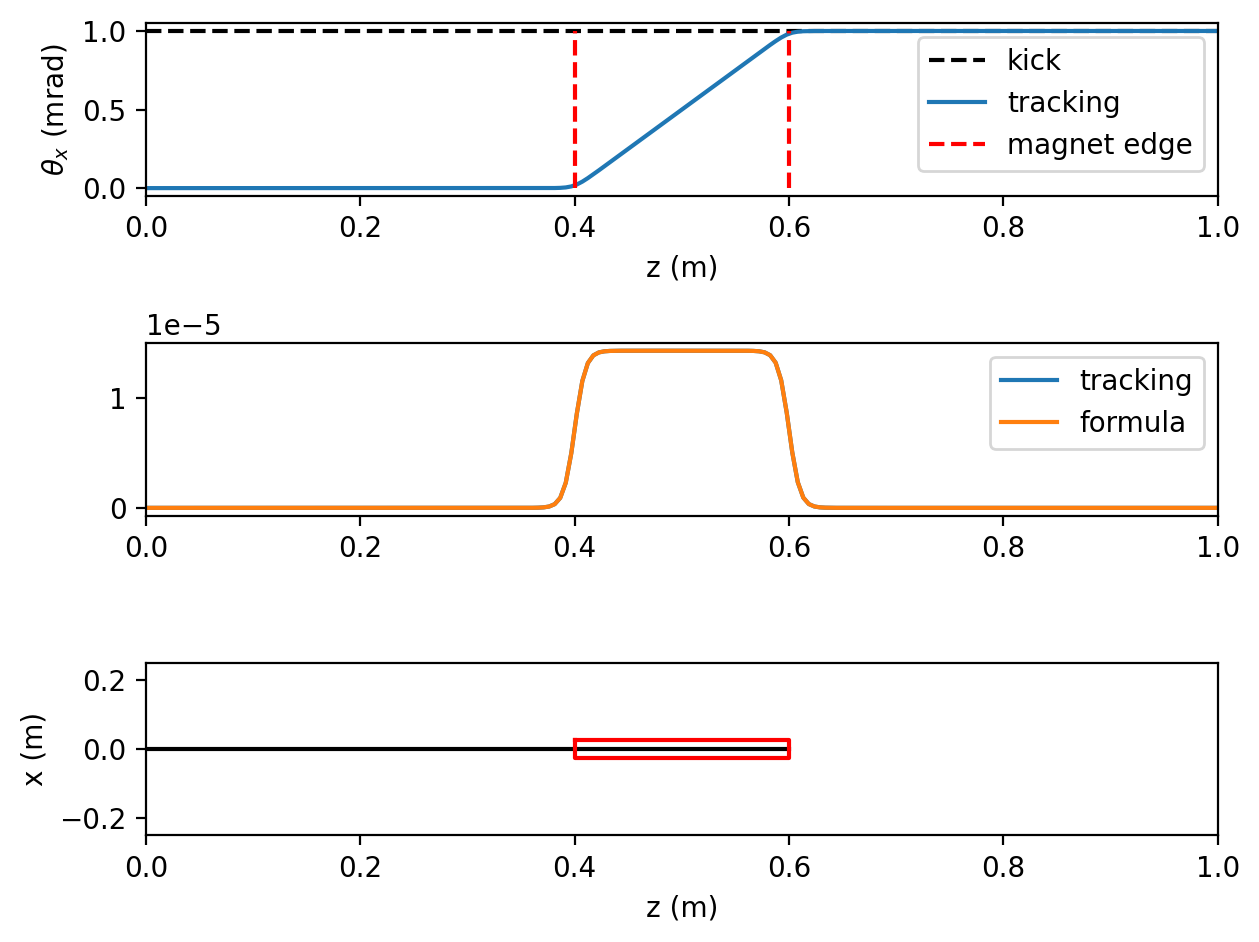

In [15]:
fig, axs = plt.subplots(3, 1)

axs[0].plot([0, 1], [1, 1], '--k')
axs[0].plot(G2.tout_stat('mean_z'), G2.tout_stat('mean_xp')*1e3);
axs[0].set_xlabel('z (m)')
axs[0].set_ylabel(r'$\theta_x$ (mrad)')
axs[0].set_xlim([0, 1])

axs[0].plot(ds + np.array([0, 0]), [0, 1], '--r')
axs[0].plot(ds + np.array([b, b]), [0, 1], '--r')

axs[0].legend(['kick', 'tracking', 'magnet edge'])

axs[1].plot(G2.tout_stat('mean_z'), G2.tout_stat('mean_fBy'))
axs[1].plot(G2.tout_stat('mean_z'), G2.lattice['kicker'].b_field(G2.tout_stat('mean_z')))
axs[1].legend(['tracking', 'formula'])
axs[1].set_xlim([0, 1])

lat.plot_floor(ax=axs[2],axis=None)
axs[2].set_xlim([0, 1])
axs[2].set_ylim([-0.25, +0.25])

plt.tight_layout()

In [16]:
if os.path.exists('gpt.temp.in'):
    os.remove('gpt.temp.in')

# Basic Tests
---

In [17]:
def check_parsing():

    lat1 = Lattice('parse_test')

    b = 0.2
    
    kick = 1e-3
    E = 1e6
    p = np.sqrt(E**2 - MC2**2)
    
    Bfield = p * kick / b / c
    
    gap = 0.01
    ds = 0.4
    
    lat1.add(Rectmagnet('kicker', 0.05, b, Bfield, gap=gap), ds = ds, element_origin='beg')
    lat1.write_gpt_lines(output_file='parse_test.temp.in');

    G = GPT('parse_test.temp.in')
    lat2 = G.lattice

    os.remove('parse_test.temp.in')

    # Basic info
    assert lat1['kicker']._length==lat2['kicker']._length
    assert lat1['kicker']._width==lat2['kicker']._width
    assert lat1['kicker']._height==lat2['kicker']._height
    assert lat1['kicker']._ecs==lat2['kicker']._ecs
    assert lat1['kicker'].name == lat2['kicker'].name

    # Element specific
    assert lat1['kicker'].a == lat2['kicker'].a
    assert lat1['kicker'].b == lat2['kicker'].b
    assert lat1['kicker']._B == lat2['kicker']._B
    assert lat1['kicker']._b1 == lat2['kicker']._b1
    assert lat1['kicker']._b2 == lat2['kicker']._b2
    assert lat1['kicker']._dl == lat2['kicker']._dl
    

check_parsing()

In [18]:
def check_kick():

    lat = Lattice('kick_test')

    b = 0.2
    
    kick = 1e-3
    E = 1e6
    p = np.sqrt(E**2 - MC2**2)
    
    Bfield = p * kick / b / c
    
    gap = 0.01
    ds = 0.4

    lat.add(Rectmagnet('kicker', 0.05, b, Bfield, gap=gap), ds = ds, element_origin='beg')
    lat.write_gpt_lines(output_file='kick_test.temp.in');

    G = GPT('kick_test.temp.in', initial_particles=single_particle(pz=p), load_all_gdf_data=True)
    G.set_variable('Ntout', 500)
    G.run()

    xp = G.tout_stat('mean_xp')*1e3

    os.remove('kick_test.temp.in')

    assert np.isclose(xp[-1], 1)

check_kick()

In [19]:
if os.path.exists('gpt.temp.in'):
    os.remove('gpt.temp.in')